In [1]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
import openpyxl
import geopandas as gpd
import math
import itertools
from scipy import stats
import scipy
import timeit
from functools import reduce
from pandas import ExcelWriter

pd.set_option('display.max_columns', None)
idx = pd.IndexSlice

In [2]:
input_path = '../../data/input/dhis2/new_system/'
input_path_old = '../../data/input/dhis2/old_system/'

shapes_path = '../../data/shapes/district/districts_17_19.shp'
facility_path = '../../data/input/hospitals/original_data/'

output_path = '../../data/output/sprint3_analysis/'

# Some functions I'll use

In [3]:
# build a small fucntion to split the string column name of the data download as pivot 

def split(strng, sep, occ):
    strng = strng.split(sep)
    return sep.join(strng[occ[1]:]), sep.join(strng[:occ[0]]), sep.join(strng[occ[0]:occ[1]])[:3]

In [4]:
# To get year on year deltas over a list of months

def get_delta(df,st_year,end_year,indic,st_month,end_month):
    delta=((df[(end_year,indic,end_month)]
            -df[(st_year,indic,st_month)])
           /df[(st_year,indic,st_month)])
    return delta

In [5]:
# To get month on month deltas

def get_yoy_delta(df,indic,period):
    tot_18 = tot_19= tot_20 = np.zeros(135)
    for month in period:
        tot_18= tot_18+list(df[('2018',indic,month)])
        tot_19= tot_19+list(df[('2019',indic,month)])
        tot_20= tot_20+list(df[('2020',indic,month)])
    delta =  (tot_20-tot_19)/tot_19
    return tot_18,tot_19,tot_20,delta

In [6]:
# Creating a dict of names to replace district names

district_name_dict = {'SEMBABULE': 'SSEMBABULE', 'MADI-OKOLLO': 'MADI OKOLLO'}

# For a fully automated one, will need to do fuzzy matching


# Fetch data


In [7]:
# To clean the data downloaded in a pivot format

def get_clean_stack(df,drop):

    df['district']=df['orgunitlevel3'].apply(lambda x: x[:-9].upper())
    df['district'].replace(district_name_dict,inplace=True)
    
    df.set_index(['district','organisationunitid'],drop=True,inplace=True)
    
    cols = np.arange(0,9)
    df.drop(df.columns[cols],axis=1,inplace=True)
    
    cols = df.columns
    new_cols=[]
    for col in cols:
        new_cols.append(split(col,' ',[-2,-1]))
    df.columns=pd.MultiIndex.from_tuples(new_cols,names=['year','indic','month'])
    
    if drop != None:
        df.drop(drop,axis=1,inplace=True,level=2)
    
    df1=df.copy().stack(level=[0,1,2],dropna=False).reset_index()
    df1.rename(columns={0:'value'},inplace=True)
    
    return df1

## New data


In [8]:
# to get all the new data files together
def fetch_new_data (filepaths):
    df = pd.DataFrame(columns = ['district', 'organisationunitid', 'year', 'indic', 'month', 'value'])
    for x in filepaths:
        x_df=get_clean_stack(pd.read_csv(x),drop='Dec')
        df=pd.concat([df,x_df])
    return df


In [9]:
# creating the new data stack

filepaths = [input_path+'new_epi_data_by_facility.csv',
            input_path+'new_mnch_data_by_facility.csv',
            input_path+'new_sam_data_by_facility.csv']

new_stack = fetch_new_data (filepaths=filepaths)
new_stack.tail()

C:\Users\Dalberg\anaconda3\envs\icohs\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,district,organisationunitid,year,indic,month,value
267500,WAKISO,nYpQROJrK2y,2020,NUT: Percentage of children/babies born with l...,Apr,NaN
267501,WAKISO,nYpQROJrK2y,2020,NUT: Percentage of children/babies born with l...,Feb,50.0
267502,WAKISO,nYpQROJrK2y,2020,NUT: Percentage of children/babies born with l...,Jan,NaN
267503,WAKISO,nYpQROJrK2y,2020,NUT: Percentage of children/babies born with l...,Mar,NaN
267504,WAKISO,nYpQROJrK2y,2020,NUT: Percentage of children/babies born with l...,May,NaN


## Old data

For now extremely messy, had to be done bit by bit in random order, so quite some cleaning needed Ill do here, than put all into one nice file

In [10]:
# to get all the old data files together
def fetch_old_data (filepaths):
    df = pd.DataFrame(columns = ['district', 'organisationunitid', 'year', 'indic', 'month', 'value'])
    for x in filepaths:
        x_df=get_clean_stack(pd.read_csv(x),drop=None)
        df=pd.concat([df,x_df])
    return df


In [11]:

# creating the old data stack

# For now a bit all over the placedue to download limitations 

filepaths = [input_path_old+"/epi/EPI - BCG doses given.csv",
             input_path_old+"/epi/EPI - DPT-HepB-HIB 1 doses given.csv",
             input_path_old+"/epi/EPI - DPT-HepB-HIB 3 doses given.csv",
             input_path_old+"/epi/EPI - PCV 1 doses given.csv",
             input_path_old+"/epi/EPI - PCV 3 doses given.csv",
             input_path_old+"/epi/EPI - MR 1 doses given.csv",
             input_path_old+'/mat/admission_newborn.csv',
             input_path_old+'/mat/ANC1_ANC4.csv',
             input_path_old+'/mat/births.csv',
             input_path_old+'/sam/lbw.csv',
             input_path_old+'/sam/sam_mam.csv']

old_stack = fetch_old_data (filepaths=filepaths)
old_stack.tail()

,district,organisationunitid,year,indic,month,value
516091,KAMPALA,mDMIY5uLZzf,2019,105-1.3 OPD Severe Acute Malnutrition Without ...,Mar,2.0
516092,KAMPALA,mDMIY5uLZzf,2019,105-1.3 OPD Severe Acute Malnutrition Without ...,May,NaN
516093,KAMPALA,mDMIY5uLZzf,2019,105-1.3 OPD Severe Acute Malnutrition Without ...,Nov,2.0
516094,KAMPALA,mDMIY5uLZzf,2019,105-1.3 OPD Severe Acute Malnutrition Without ...,Oct,NaN
516095,KAMPALA,mDMIY5uLZzf,2019,105-1.3 OPD Severe Acute Malnutrition Without ...,Sep,NaN


In [12]:
old_stack['indic'].unique()

array(['EPI - BCG doses given', 'EPI - DPT-HepB-HIB 1 doses given',
       'EPI - DPT-HepB-HIB 3 doses given', 'EPI - PCV 1 doses given',
       'EPI - PCV 3 doses given', 'EPI - MR 1 doses given',
       '105-2.2 Admissions', '105-2.2 Newborn deaths (0-7days)',
       '105-2.3 Postnatal Attendances',
       '105-2.1 A1:ANC 1st Visit for women',
       '105-2.1 A2:ANC 4th Visit for women',
       '105-2.2a Deliveries in unit',
       '105-2.2b Deliveries in unit(Fresh Still births)',
       '105-2.2c Deliveries in unit(Macerated still births)',
       '105-2.2d Deliveries in unit(Live Births)',
       'Percentage of babies born with low birth weight (<2500 g)',
       'Underweight rate of children under 5',
       '105-1.3 OPD Moderate Acute Malnutrition (MAM)',
       '105-1.3 OPD Severe Acute Malnutrition With Oedema',
       '105-1.3 OPD Severe Acute Malnutrition Without Oedema'],
      dtype=object)

# Merge the two

## Select a subset of indicators to merge on

This is done in Excel manually, after running the small function below

In [13]:
#with ExcelWriter(input_path+'new_old_correspondance.xlsx',mode='a') as writer:
    #pd.Series(old_stack['indic'].unique()).to_excel(writer,sheet_name='old_vars')
    #pd.Series(new_stack['indic'].unique()).to_excel(writer,sheet_name='new_vars')

Here I get back the result into a dict

In [14]:
from pandas import ExcelFile
xls = ExcelFile(input_path+'new_old_correspondance.xlsx')
df = xls.parse(xls.sheet_names[0])
df.set_index('Old',drop=True,inplace=True)
old_new_dict=df['New'].to_dict()
old_new_dict

{'105-2.1 A1:ANC 1st Visit for women': '105-AN01a. ANC 1st Visit for women',
 '105-2.1 A2:ANC 4th Visit for women': '105-AN02. ANC 4th Visit for women',
 '105-2.2 Admissions': '105-MA01. Admissions',
 '105-2.2 Newborn deaths (0-7days)': '105-MA04a. Deliveries in unit - Total',
 '105-2.2a Deliveries in unit': '105-MA04b1. Deliveries in unit -Live births - Total',
 '105-2.2b Deliveries in unit(Fresh Still births)': '105-MA04c1. Deliveries in unit - Fresh still birth - Total',
 '105-2.2c Deliveries in unit(Macerated still births)': '105-MA04d1. Deliveries in unit - Macerated still birth - Total',
 '105-2.2d Deliveries in unit(Live Births)': '105-MA11. Newborn deaths (0-7 days)',
 '105-2.3 Postnatal Attendances': '105-PN01a. Post Natal Attendances - Mother',
 'EPI - BCG doses given': 'EPI - BCG doses given',
 'EPI - DPT-HepB-HIB 1 doses given': 'EPI - DPT-HepB-HIB 1 doses given',
 'EPI - DPT-HepB-HIB 3 doses given': 'EPI - DPT-HepB-HIB 3 doses given',
 'EPI - MR 1 doses given': 'EPI - MR 1

In [15]:
# Replacing the old names by the new

old_stack.replace({'indic': old_new_dict},inplace=True)

In [16]:
# Store my target indicators

target_indics=list(old_new_dict.values())

### Check there is no issue with facility ids

In [17]:
def test_ids_diff():
    old_ids=set(old_stack['organisationunitid'].unique())
    new_ids=set(new_stack['organisationunitid'].unique())
    return print("\nThe old dataset has ",str(len(old_ids))," facilities\n",
                 "The new dataset has ",str(len(new_ids))," facilities\n",
                 'The difference is ',str(len(new_ids)-len(old_ids)),"\n\n",
                 "However, the difference between the two sets suggest many ids have changed :\n",
                 str(len(new_ids.difference(old_ids)))," ids found in the new data sets are not in the old\n",
                 str(len(old_ids.difference(new_ids)))," ids found in the old data sets are not in the new\n")
test_ids_diff()


The old dataset has  7168  facilities
 The new dataset has  7643  facilities
 The difference is  475 

 However, the difference between the two sets suggest many ids have changed :
 1927  ids found in the new data sets are not in the old
 1452  ids found in the old data sets are not in the new



In [18]:
# Store ids

old_ids=set(old_stack['organisationunitid'].unique())
new_ids=set(new_stack['organisationunitid'].unique())

In [19]:
def test_ids_excl():
    valid_ids=list(old_ids.intersection(new_ids))
    old_stack_target=old_stack[old_stack['indic'].isin(target_indics)].copy()
    new_stack_target=new_stack[new_stack['indic'].isin(target_indics)].copy()
    
    data=old_stack_target['value'].values
    old_count_all_ids = data.size - np.isnan(data).sum()
    data=new_stack_target['value'].values
    new_count_all_ids = data.size - np.isnan(data).sum()
    
    old_stack_target=old_stack[old_stack['indic'].isin(target_indics) & old_stack['organisationunitid'].isin(valid_ids)].copy()
    new_stack_target=new_stack[new_stack['indic'].isin(target_indics) & new_stack['organisationunitid'].isin(valid_ids)].copy()
    
    data=old_stack_target['value'].values
    old_count_select_ids = data.size - np.isnan(data).sum()
    data=new_stack_target['value'].values
    new_count_select_ids = data.size - np.isnan(data).sum()
    
    old_loss = round((old_count_all_ids-old_count_select_ids)/old_count_all_ids*100,2)
    new_loss = round((new_count_all_ids-new_count_select_ids)/new_count_all_ids*100,2)
    all_loss = round(((new_count_all_ids-new_count_select_ids)+(old_count_all_ids-old_count_select_ids))/(new_count_all_ids+old_count_all_ids)*100,2)
    
    return print ("Across both datasets, the exclusion of non-matching facility ids results in a loss of ",all_loss,"% of data points\n",
      "broken down as ",new_loss,"% of the new data and ",old_loss,"% of the old.")

test_ids_excl()

Across both datasets, the exclusion of non-matching facility ids results in a loss of  1.11 % of data points
 broken down as  3.71 % of the new data and  0.69 % of the old.


Possible next step: be able to identify the facilities that were genuinely created recently - see if this data is available

In [20]:
# Store the valid ids

old_ids=set(old_stack['organisationunitid'].unique())
new_ids=set(new_stack['organisationunitid'].unique())
valid_ids=list(old_ids.intersection(new_ids))


### Get only the bits of data I am interested in

In [21]:
old_stack_t=old_stack[old_stack['indic'].isin(target_indics) & old_stack['organisationunitid'].isin(valid_ids)].copy()
new_stack_t=new_stack[new_stack['indic'].isin(target_indics) & new_stack['organisationunitid'].isin(valid_ids)].copy()

In [22]:
stack_t=pd.concat([old_stack_t,new_stack_t])
stack_t.head()

,district,organisationunitid,year,indic,month,value
0,ZOMBO,XikHv88zzDn,2018,EPI - BCG doses given,Apr,7.0
1,ZOMBO,XikHv88zzDn,2018,EPI - BCG doses given,Aug,7.0
2,ZOMBO,XikHv88zzDn,2018,EPI - BCG doses given,Dec,5.0
3,ZOMBO,XikHv88zzDn,2018,EPI - BCG doses given,Feb,NaN
4,ZOMBO,XikHv88zzDn,2018,EPI - BCG doses given,Jan,NaN


## Note on Nutrition data 

SAM and MAM need to be looked at in detail, becausethe trend deosnt seem to make sense

In [23]:
def get_mean_oct_19_apr_20(indic):
    sam_mam_test = pd.DataFrame(columns=['year','month','value'])
    sam_mam_test.set_index(['year','month'],drop=True,inplace=True)

    for m in ['Oct','Nov','Dec']:
        a = stack_t[(stack_t['indic']==indic) & 
                    (stack_t['year']=='2019') &
                    (stack_t['month']==m)].mean()
        sam_mam_test.loc[('2019',m),:]=a

    for m in ['Jan','Feb','Mar','Apr']:
        a = stack_t[(stack_t['indic']==indic) & 
                    (stack_t['year']=='2020') &
                    (stack_t['month']==m)].mean()
        sam_mam_test.loc[('2020',m),:]=a
    sam_mam_test.rename({'value':indic},axis=1,inplace=True)
    return sam_mam_test

In [24]:
print(get_mean_oct_19_apr_20('105-NA03c1. Identified malnourished clients(<10) this month - SAM using MUAC -  Without Oedema'),"\n\n",
     get_mean_oct_19_apr_20('105-NA03a1. Identified malnourished clients(<10) this month - MAM using MUAC'))

           105-NA03c1. Identified malnourished clients(<10) this month - SAM using MUAC -  Without Oedema
year month                                                                                               
2019 Oct                                              6.90585                                            
     Nov                                              6.81306                                            
     Dec                                              6.22617                                            
2020 Jan                                               6.1954                                            
     Feb                                                 6.35                                            
     Mar                                              5.73413                                            
     Apr                                              4.98829                                             

            105-NA03a1. Identified malnouris

# Flag outliers

# Put our data in the right format 

For some reason, if I use dropna=False on my pivot, ittakes ages to laod


In [25]:
%%time

def pivot_stack(df):
    pivot_outliers=df.copy().pivot_table(index=['district', 'organisationunitid', 'indic'], columns=['year','month' ]) #,dropna=False)
    pivot_outliers.rename(columns={'value':'with_outiers'},level=0,inplace=True)
    pivot_outliers.columns.rename('type', level=0, inplace=True)
    pivot_outliers.dropna(how='all',axis=0,inplace=True) # looks like there is no all na line to drop
    
    return pivot_outliers

pivot_outliers=pivot_stack(stack_t)

Wall time: 4.06 s


In [26]:
a = round(((stack_t['value'].size-pivot_outliers.size)/stack_t['value'].size)*100,1)
print("Note that the pivot/unpivot process deletes the all Nan rows (so about ",str(a),"% of data points), which is fine at this stage")

Note that the pivot/unpivot process deletes the all Nan rows (so about  33.7 % of data points), which is fine at this stage


## Checking for the distribution of the data (WIP)

Need to make sure this is not an issue with how I have nornalized the data, 
- if there are only a few numbers for each facilitues its easy to always hit the min or max (so appear as o or 1)
- possible nan values in the columns actuallygive me zeros instead of nans

I would also need to examine if my outlier exclusion porcedure makes it look a little bit better 

If not, I might just need to revert back to the IQR approach

In [27]:
pivot_outliers

type                                                                           with_outiers  \
year                                                                                   2018   
month                                                                                   Apr   
district organisationunitid indic                                                             
ABIM     JO1cLIghdBv        105-AN01a. ANC 1st Visit for women                         17.0   
                            105-AN02. ANC 4th Visit for women                           5.0   
                            105-MA01. Admissions                                        7.0   
                            105-MA04a. Deliveries in unit - Total                       0.0   
                            105-MA04b1. Deliveries in unit -Live births - T...          7.0   
...                                                                                     ...   
ZOMBO    vFo5oNkc7Nn        EPI - DPT-HepB-HIB 3 doses given                           23.0   
                            EPI - MR 1 doses given                                     38.0   
                            EPI - PCV 1 doses_Under 1                                  24.0   
                            EPI - PCV 3 doses_Under 1                                  17.0   
                            NUT: Percentage of children/babies born with lo...         11.1   

type                                                                                  \
year                                                                                   
month                                                                            Aug   
district organisationunitid indic                                                      
ABIM     JO1cLIghdBv        105-AN01a. ANC 1st Visit for women                  21.0   
                            105-AN02. ANC 4th Visit for women                    6.0   
                            105-MA01. Admissions                                14.0   
                            105-MA04a. Deliveries in unit - Total                NaN   
                            105-MA04b1. Deliveries in unit -Live births - T...  14.0   
...                                                                              ...   
ZOMBO    vFo5oNkc7Nn        EPI - DPT-HepB-HIB 3 doses given                    53.0   
                            EPI - MR 1 doses given                              56.0   
                            EPI - PCV 1 doses_Under 1                           50.0   
                            EPI - PCV 3 doses_Under 1                           43.0   
                            NUT: Percentage of children/babies born with lo...   5.7   

type                                                                                  \
year                                                                                   
month                                                                            Dec   
district organisationunitid indic                                                      
ABIM     JO1cLIghdBv        105-AN01a. ANC 1st Visit for women                   6.0   
                            105-AN02. ANC 4th Visit for women                    3.0   
                            105-MA01. Admissions                                 4.0   
                            105-MA04a. Deliveries in unit - Total                NaN   
                            105-MA04b1. Deliveries in unit -Live births - T...   4.0   
...                                                                              ...   
ZOMBO    vFo5oNkc7Nn        EPI - DPT-HepB-HIB 3 doses given                    27.0   
                            EPI - MR 1 doses given                              39.0   
                            EPI - PCV 1 doses_Under 1                           26.0   
                            EPI - PCV 3 doses_Under 1                           27.0   
                     

In [28]:
def get_norm_data(pivot):
    pivot1=pivot.copy()
    
    pivot1['max']=pivot1.max(axis=1)
    pivot1['min']=pivot1.min(axis=1)

    for x in pivot1.columns[:-2]:
        pivot1[x]=(pivot1[x]-pivot1['min'])/(pivot1['max']-pivot1['min'])
        
    pivot1.drop(['max','min'],axis=1,inplace=True)
    
    stack = pivot1.stack(level=[0,1,2],dropna=False).reset_index()
    stack.rename(columns={0:'value'},inplace=True)
    
    return stack

In [29]:
stack_t_1=get_norm_data(pivot_outliers)
stack_t_1.head()

,district,organisationunitid,indic,type,year,month,value
0,ABIM,JO1cLIghdBv,105-AN01a. ANC 1st Visit for women,with_outiers,2018,Apr,0.764706
1,ABIM,JO1cLIghdBv,105-AN01a. ANC 1st Visit for women,with_outiers,2018,Aug,1.000000
2,ABIM,JO1cLIghdBv,105-AN01a. ANC 1st Visit for women,with_outiers,2018,Dec,0.117647
3,ABIM,JO1cLIghdBv,105-AN01a. ANC 1st Visit for women,with_outiers,2018,Feb,0.235294
4,ABIM,JO1cLIghdBv,105-AN01a. ANC 1st Visit for women,with_outiers,2018,Jan,NaN


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

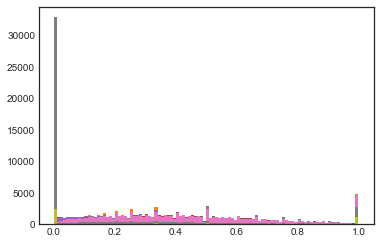

In [31]:
hists=[]
for x in list(stack_t_1['indic'].unique()):
        a = stack_t_1[stack_t_1['indic']==x]['value'].dropna(how='all')
        b = plt.hist(a,bins=100)
        hists.append(b)

(array([6638.,  988., 1094., 1053., 1102., 1185., 1182., 1084., 1209.,
        1138., 1338., 1291., 1269., 1192., 1328., 1359., 1424., 1176.,
        1297., 1033., 1659., 1272., 1347., 1354.,  963., 1909., 1262.,
        1248., 1306., 1175., 1540., 1256., 1103., 1657., 1287., 1166.,
        1270., 1289., 1279.,  875., 1621., 1201., 1286., 1051., 1142.,
        1237., 1068., 1016., 1052.,  351., 1920.,  906., 1035.,  932.,
         932.,  923.,  850.,  916.,  839.,  575., 1016.,  762.,  772.,
         681.,  651.,  704.,  934.,  489.,  672.,  722.,  508.,  554.,
         557.,  485.,  321.,  673.,  541.,  464.,  435.,  256.,  545.,
         422.,  350.,  362.,  334.,  393.,  328.,  270.,  325.,  218.,
         338.,  202.,  211.,  209.,  225.,  187.,  180.,  138.,   88.,
        4548.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29

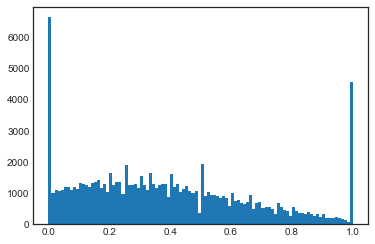

In [32]:
a = stack_t_1[stack_t_1['indic']=='EPI - MR 1 doses given']['value'].dropna(how='all')
plt.hist(a,bins=100)

In [33]:
stack_t_1[stack_t_1['indic']=='EPI - MR 1 doses given']['value'].value_counts(dropna=True)

0.000000    5755
1.000000    4535
0.500000    1574
0.333333    1343
0.250000    1034
            ... 
0.031902       1
0.674897       1
0.409722       1
0.077295       1
0.608247       1
Name: value, Length: 9734, dtype: int64

## Replace outliers using a std deviation method (WIP, might need to switch to IQR)

In [34]:
# Get the data in the right format

def replace_outliers(pivot_outliers,cutoff):#df
    
    pivot_no_outliers=pd.DataFrame(columns=pivot_outliers.columns,index=pivot_outliers.index)
    pivot_no_outliers.rename(columns={'with_outiers':'without_outliers'},level=0,inplace=True)
    
    for x in pivot_outliers.index: # to exclude
        values = pivot_outliers.loc[x,:].values
        if np.nanstd(values)!=0 and np.isnan(values).sum()!=len(values):
            zscore = abs(stats.zscore(values,nan_policy='omit'))
            new_values = np.where(zscore>cutoff,np.nanmedian(values),values)

        else:
            new_values = values

        pivot_no_outliers.iloc[pivot_outliers.index.get_loc(x),:] = new_values.astype('float')

    return pivot_no_outliers 


In [35]:
%%time
pivot_no_outliers = replace_outliers(pivot_outliers,cutoff=3)


<ipython-input-34-34eb04742e5b>:12: RuntimeWarning: invalid value encountered in greater
  new_values = np.where(zscore>cutoff,np.nanmedian(values),values)


Wall time: 1min 12s


## Stack the outlier corrected data

In [36]:
def pivot_stack(pivot):
    stack = pivot.stack(level=[0,1,2],dropna=False).reset_index()
    stack.rename(columns={0:'value'},inplace=True)
    return stack

stack_t_noout=pivot_stack(pivot_no_outliers)

In [37]:
print("\n",
      "It appears that the pivot unpivot process creates and deletes Nan values as it goes. Looking at data size at each step:\n\n",
      str(stack_t['value'].size),str(pivot_outliers.size),str(pivot_no_outliers.size),str(stack_t_noout['value'].size),"\n\n",
      "That is however ok because non-NaN values seem to only change at the outlier exclusin pahse, which is what we want :\n\n",
      str(round(stack_t['value'].sum(),1)),
      str(round(pivot_outliers.sum().sum(),1)),
      str(round(pivot_no_outliers.sum().sum(),1)),
      str(round(stack_t_noout['value'].sum(),1)))


 It appears that the pivot unpivot process creates and deletes Nan values as it goes. Looking at data size at each step:

 3149516 2089015 2089015 2593260 

 That is however ok because non-NaN values seem to only change at the outlier exclusin pahse, which is what we want :

 46397974.2 46397974.2 43470942.8 43470942.8


In [38]:
# Two small adjustement essential to comparison wit stack_t

stack_t_noout.drop('type',axis=1,inplace=True)
stack_t_noout['value']=stack_t_noout['value'].astype(dtype='float64')


In [39]:
stack_t_noout.dtypes

district               object
organisationunitid     object
indic                  object
year                   object
month                  object
value                 float64
dtype: object

In [40]:
stack_t.dtypes

district               object
organisationunitid     object
year                   object
indic                  object
month                  object
value                 float64
dtype: object

In [41]:
stack_t_noout.head()

,district,organisationunitid,indic,year,month,value
0,ABIM,JO1cLIghdBv,105-AN01a. ANC 1st Visit for women,2018,Apr,17.0
1,ABIM,JO1cLIghdBv,105-AN01a. ANC 1st Visit for women,2018,Aug,21.0
2,ABIM,JO1cLIghdBv,105-AN01a. ANC 1st Visit for women,2018,Dec,6.0
3,ABIM,JO1cLIghdBv,105-AN01a. ANC 1st Visit for women,2018,Feb,8.0
4,ABIM,JO1cLIghdBv,105-AN01a. ANC 1st Visit for women,2018,Jan,NaN


## Check and reacord whihc data points were changed (WIP)

def check_dropped_datapoints():
    
    stack_t_noout['concat']=stack_t_noout['district']+stack_t_noout['organisationunitid']+stack_t_noout['year']+stack_t_noout['indic']+stack_t_noout['month']
    stack_t['concat']=stack_t['district']+stack_t['organisationunitid']+stack_t['year']+stack_t['indic']+stack_t['month']
    
    dropped_rows=list(set(stack_t_noout['concat']).difference(set(stack_t['concat'])))
    
    a = len(set(stack_t_noout['concat']))
    b = len(set(stack_t['concat']))
    c = len(set(stack_t_noout['concat']).difference(set(stack_t['concat'])))
    d = stack_t_noout[stack_t_noout['concat'].isin(dropped_rows)]['value'].unique()
    
    stack_t_noout.drop('concat',inplace=True,axis=1)
    stack_t.drop('concat',inplace=True,axis=1)
    
    return a,b,c,d

a,b,c,d = check_dropped_datapoints()


print("Note that the size of data chnages between the two stacked version, but the is only due to NaN values being added/takend out:\n\n",
     "- The no_outlier data has ",str(a)," data points, vs ",str(b)," for the full data set\n",
     "- The weord thing is that the inner joint is smaller than both, with ",str(c)," datapoints dropped from the no_outlier data\n\n",
      "After investigating, this difference is acounted by Nan values only:",str(d))

%%time

def check_out_changes(df_out,df_noout):
    
    df_out.set_index(['district','organisationunitid','year','indic','month'],inplace=True,drop=True)
    df_noout.set_index(['district','organisationunitid','year','indic','month'],inplace=True,drop=True)
    df=pd.merge(df_out,df_noout,how='inner',left_index=True,right_index=True)
    
    changed = df[df['value_x'] != df['value_x']]
    #changed.columns.rename(['original','changed'],inplace=True)
    
    df_out.reset_index(inplace=True)
    df_noout.reset_index(inplace=True)
    
    return  changed

changes_made=check_out_changes(stack_t,stack_t_noout)
changes_made

a=pd.DataFrame([1,np.nan,3,np.nan,5])
b=pd.DataFrame([1,2,3,np.nan,4])
c=pd.merge(a,b,left_index=True,right_index=True)
c['comp']=(c['0_x'] - c['0_y'])
c

print ("The outlier exclusion process transformed ",str(len(changes_mad))," data points\n\n",
       "The total of all values betwwen the cleaned and original dataset has changed by ",
       str(round(((stack_t['value'].sum()-stack_t_noout['value'].sum())/stack_t['value'].sum())*100,2))," %.")

# Look at reporting rate 

Start back from the flat data, not the pivot!

Make sure there is no Nan Data being dropped in stacking teh data

## Build the reprting rate 

In [42]:
stack_reporting = stack_t.groupby(['district', 'year', 'indic', 'month']).count().rename(columns={'organisationunitid':'total','value':'reported'})
stack_reporting['report_rate']=stack_reporting['reported']/stack_reporting['total']

id_count = stack_reporting['total'].sum()/(29*19)

print("This matches exactly with the total number of valid ids we looked at: ",str(len(valid_ids))," vs ", str(id_count),
     "\n\nWhile the number of district is also coherent:",str(len(stack_reporting)/(19*29)))

This matches exactly with the total number of valid ids we looked at:  5716  vs  5716.0 

While the number of district is also coherent: 135.0


In [43]:
stack_reporting.head()

total  reported  \
district year indic                              month                    
ABIM     2018 105-AN01a. ANC 1st Visit for women Apr       21        18   
                                                 Aug       21        18   
                                                 Dec       21        18   
                                                 Feb       21        16   
                                                 Jan       21         0   

                                                        report_rate  
district year indic                              month               
ABIM     2018 105-AN01a. ANC 1st Visit for women Apr       0.857143  
                                                 Aug       0.857143  
                                                 Dec       0.857143  
                                                 Feb       0.761905  
                                                 Jan       0.000000

## Group my original and outlier corrected data by district

In [44]:
# to check any data point below:

stack_t[(stack_t['district']=='ABIM') & 
        (stack_t['year']=='2018') & 
        (stack_t['indic']=='105-AN01a. ANC 1st Visit for women') & 
        (stack_t['month']=='Jan')]['value'].sum(min_count=1)

nan

In [45]:
stack_dis_out = stack_t.groupby(['district', 'year', 'indic', 'month']).sum(min_count=1)
stack_dis_out.head()

value
district year indic                              month       
ABIM     2018 105-AN01a. ANC 1st Visit for women Apr    340.0
                                                 Aug    494.0
                                                 Dec    394.0
                                                 Feb    416.0
                                                 Jan      NaN

In [46]:
# to check any data point below:

stack_t_noout[(stack_t_noout['district']=='ABIM') & 
        (stack_t_noout['year']=='2018') & 
        (stack_t_noout['indic']=='105-AN01a. ANC 1st Visit for women') & 
        (stack_t_noout['month']=='Jan')]['value'].sum(min_count=1,skipna=True)

nan

In [47]:
stack_dis_noout = stack_t_noout.groupby(['district', 'year', 'indic', 'month'],).sum(min_count=1)
stack_dis_noout.head()

value
district year indic                              month       
ABIM     2018 105-AN01a. ANC 1st Visit for women Apr    340.0
                                                 Aug    494.0
                                                 Dec    347.5
                                                 Feb    416.0
                                                 Jan      NaN

Note that I had an issue at this stage, with the code for stack_dis_noout returning 0 instead of NaN for a sum of all NaN elements, Turns out it was an issue with the column type of 'value',set to 'O' instead of 'float64'

## Put it all together

In [48]:
data_decrease = round(abs((stack_dis_noout.sum().value-stack_dis_out.sum().value)/stack_dis_out.sum().value)*100,2)

print('Overall, the total of all data decreased by ',str(data_decrease)," %.")

Overall, the total of all data decreased by  6.31  %.


In [49]:
print (len(stack_reporting),len(stack_dis_out),len(stack_dis_noout))

74385 74385 92340


In [50]:
dis_stack_final=pd.merge(stack_reporting,stack_dis_out,how='left',right_index=True,left_index=True).rename(columns={'value':'sum_out'})
dis_stack_final=pd.merge(dis_stack_final,stack_dis_noout,how='left',right_index=True,left_index=True).rename(columns={'value':'sum_noout'})
dis_stack_final.reset_index(inplace=True)
dis_stack_final.head()

,district,year,indic,month,total,reported,report_rate,sum_out,sum_noout
0,ABIM,2018,105-AN01a. ANC 1st Visit for women,Apr,21,18,0.857143,340.0,340.0
1,ABIM,2018,105-AN01a. ANC 1st Visit for women,Aug,21,18,0.857143,494.0,494.0
2,ABIM,2018,105-AN01a. ANC 1st Visit for women,Dec,21,18,0.857143,394.0,347.5
3,ABIM,2018,105-AN01a. ANC 1st Visit for women,Feb,21,16,0.761905,416.0,416.0
4,ABIM,2018,105-AN01a. ANC 1st Visit for women,Jan,21,0,0.000000,NaN,NaN


In [64]:
dis_pivot_final=dis_stack_final.pivot_table(index=['district','year','month'], columns=['indic'])
dis_pivot_final.drop('total',axis=1,inplace=True)

for i in list(dis_pivot_final.columns.levels[1]):
    dis_pivot_final[('sum_out_adj',i)] = dis_pivot_final[('sum_out',i)]*(1/dis_pivot_final[('report_rate',i)])
    
for i in list(dis_pivot_final.columns.levels[1]):
    dis_pivot_final[('sum_noout_adj',i)] = dis_pivot_final[('sum_noout',i)]*(1/dis_pivot_final[('report_rate',i)])
dis_pivot_final=dis_pivot_final.stack(level=[0])
dis_pivot_final.head()

indic                              105-AN01a. ANC 1st Visit for women  \
district year month                                                     
ABIM     2018 Apr   report_rate                              0.857143   
                    reported                                18.000000   
                    sum_noout                              340.000000   
                    sum_noout_adj                          396.666667   
                    sum_out                                340.000000   

indic                              105-AN02. ANC 4th Visit for women  \
district year month                                                    
ABIM     2018 Apr   report_rate                             0.809524   
                    reported                               17.000000   
                    sum_noout                             146.000000   
                    sum_noout_adj                         180.352941   
                    sum_out                               146.000000   

indic                              105-MA01. Admissions  \
district year month                                       
ABIM     2018 Apr   report_rate                0.857143   
                    reported                  18.000000   
                    sum_noout                412.000000   
                    sum_noout_adj            480.666667   
                    sum_out                  412.000000   

indic                              105-MA04a. Deliveries in unit - Total  \
district year month                                                        
ABIM     2018 Apr   report_rate                                 0.238095   
                    reported                                    5.000000   
                    sum_noout                                   1.000000   
                    sum_noout_adj                               4.200000   
                    sum_out                                     1.000000   

indic                              105-MA04b1. Deliveries in unit -Live births - Total  \
district year month                                                                      
ABIM     2018 Apr   report_rate                                             0.857143     
                    reported                                               18.000000     
                    sum_noout                                             301.000000     
                    sum_noout_adj                                         351.166667     
                    sum_out                                               301.000000     

indic                              105-MA04c1. Deliveries in unit - Fresh still birth - Total  \
district year month                                                                             
ABIM     2018 Apr   report_rate                                             0.333333            
                    reported                                                7.000000            
                    sum_noout                                               1.000000            
                    sum_noout_adj                                           3.000000            
                    sum_out                                                 1.000000            

indic                              105-MA04d1. Deliveries in unit - Macerated still birth - Total  \
district year month                                                                                 
ABIM     2018 Apr   report_rate                                             0.333333                
                    reported                                                7.000000                
                    sum_noout                                               1.000000                
                    sum_noout_adj                                           3.000000                
                    sum_out                                                 1.000000                

indic            

## Get that to csv

In [65]:
pivot_export=dis_pivot_final.copy()
#pivot_export.columns=pivot_export.columns.map("_".join)
pivot_export.to_csv(output_path+'corrected_data_district.csv')

# Alternatively, use the faciity level directly

In [54]:
# to check any data point below:

stack_t[(stack_t['organisationunitid']=='JO1cLIghdBv') & 
        (stack_t['year']=='2018') & 
        (stack_t['indic']=='105-NA03e1. Identified malnourished clients(<10) this month - SAM With Oedema') & 
        (stack_t['month']=='Apr')]['value'].notna()

124860    False
Name: value, dtype: bool

In [55]:
fac_stack_final = pd.merge(stack_t,stack_t_noout,how='inner',
                           left_on=['district', 'organisationunitid', 'year', 'indic', 'month'],
                           right_on=['district', 'organisationunitid', 'year', 'indic', 'month']).rename(columns={'value_x':'value_noout','value_y':'value_out'})

fac_stack_final['reported'] = fac_stack_final['value_out'].notna().astype('int')

fac_stack_final.head()

,district,organisationunitid,year,indic,month,value_noout,value_out,reported
0,ZOMBO,XikHv88zzDn,2018,EPI - BCG doses given,Apr,7.0,7.0,1
1,ZOMBO,XikHv88zzDn,2018,EPI - BCG doses given,Aug,7.0,7.0,1
2,ZOMBO,XikHv88zzDn,2018,EPI - BCG doses given,Dec,5.0,5.0,1
3,ZOMBO,XikHv88zzDn,2018,EPI - BCG doses given,Feb,NaN,NaN,0
4,ZOMBO,XikHv88zzDn,2018,EPI - BCG doses given,Jan,NaN,NaN,0


In [56]:
fac_pivot_final=fac_stack_final.pivot_table(index=['district','organisationunitid','year','month'], columns=['indic'])

# The pivot creates new NaN values, that need to bereplaced by False for the 'reported' metric

for i in list(fac_pivot_final.columns.levels[1]):
    fac_pivot_final[('reported',i)].replace({np.nan:0},inplace=True)
    
fac_pivot_final.head()


reported  \
indic                                  105-AN01a. ANC 1st Visit for women   
district organisationunitid year month                                      
ABIM     JO1cLIghdBv        2018 Apr                                  1.0   
                                 Aug                                  1.0   
                                 Dec                                  1.0   
                                 Feb                                  1.0   
                                 Jan                                  0.0   

                                                                          \
indic                                  105-AN02. ANC 4th Visit for women   
district organisationunitid year month                                     
ABIM     JO1cLIghdBv        2018 Apr                                 1.0   
                                 Aug                                 1.0   
                                 Dec                                 1.0   
                                 Feb                                 1.0   
                                 Jan                                 1.0   

                                                             \
indic                                  105-MA01. Admissions   
district organisationunitid year month                        
ABIM     JO1cLIghdBv        2018 Apr                    1.0   
                                 Aug                    1.0   
                                 Dec                    1.0   
                                 Feb                    1.0   
                                 Jan                    0.0   

                                                                              \
indic                                  105-MA04a. Deliveries in unit - Total   
district organisationunitid year month                                         
ABIM     JO1cLIghdBv        2018 Apr                                     1.0   
                                 Aug                                     0.0   
                                 Dec                                     0.0   
                                 Feb                                     0.0   
                                 Jan                                     1.0   

                                                                                            \
indic                                  105-MA04b1. Deliveries in unit -Live births - Total   
district organisationunitid year month                                                       
ABIM     JO1cLIghdBv        2018 Apr                                                  1.0    
                                 Aug                                                  1.0    
                                 Dec                                                  1.0    
                                 Feb                                                  1.0    
                                 Jan                                                  1.0    

                                                                                                   \
indic                                  105-MA04c1. Deliveries in unit - Fresh still birth - Total   
district organisationunitid year month                                                              
ABIM     JO1cLIghdBv        2018 Apr                                                  1.0           
                                 Aug                                                  0.0           
                                 Dec                                                  0.0           
                                 Feb                                                  0.0           
                                 Jan                                                  0.0           

                                                                                                       \
indic                     

In [57]:
pivot_export=fac_pivot_final.copy()
pivot_export.columns=pivot_export.columns.map("_".join)
pivot_export.to_csv(output_path+'corrected_data_facility.csv')

# Some data checks for interesting data points 

It looks like some data is so crazy I would need to apply several layers of outlier exclsuion, or alternatively or explore if IQR would solve the issue

In [58]:
# to check any data point below:

stack_t_noout[(stack_t_noout['organisationunitid']=='xuCJ8NBomxP') & 
        (stack_t_noout['year']=='2020') & 
        (stack_t_noout['indic']=='NUT: Percentage of children/babies born with low birth weight (<2.5kg)') & 
        (stack_t_noout['month']=='Apr')]['value']

412620    93.6
Name: value, dtype: float64

In [59]:
# to check any data point below:

stack_t[(stack_t['organisationunitid']=='xuCJ8NBomxP') & 
        (stack_t['year']=='2020') & 
        (stack_t['indic']=='NUT: Percentage of children/babies born with low birth weight (<2.5kg)') & 
        (stack_t['month']=='Apr')]['value']

70240    93.6
Name: value, dtype: float64

In [60]:
stack_t[(stack_t['organisationunitid']=='xuCJ8NBomxP') & 
        (stack_t['indic']=='NUT: Percentage of children/babies born with low birth weight (<2.5kg)')]['value']

87024       8.6
87025       9.6
87026       7.8
87027      12.4
87028       NaN
87029       7.9
87030       5.9
87031       6.9
87032       4.0
87033       8.3
87034       4.2
87035       4.9
87048       9.1
87049       5.6
87050       1.7
87051       5.0
87052       6.4
87053       5.9
87054       5.7
87055    6769.3
87056       5.0
87057       8.4
87058       7.8
87059       5.9
70240      93.6
70241       5.3
70242       8.2
70243       3.9
70244       NaN
Name: value, dtype: float64

In [61]:
stack_t_noout[(stack_t_noout['organisationunitid']=='xuCJ8NBomxP') & 
        (stack_t_noout['indic']=='NUT: Percentage of children/babies born with low birth weight (<2.5kg)')]['value']

412596     8.6
412597     9.6
412598     7.8
412599    12.4
412600     NaN
412601     7.9
412602     5.9
412603     6.9
412604     4.0
412605     8.3
412606     4.2
412607     4.9
412608     9.1
412609     5.6
412610     1.7
412611     5.0
412612     6.4
412613     5.9
412614     5.7
412615     6.4
412616     5.0
412617     8.4
412618     7.8
412619     5.9
412620    93.6
412621     NaN
412622     NaN
412623     5.3
412624     8.2
412625     NaN
412626     NaN
412627     3.9
412628     NaN
412629     NaN
412630     NaN
412631     NaN
Name: value, dtype: float64